In [1]:
import torch
import numpy as np

torch.__version__

'2.0.0+cu117'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F          
from torch.utils.data import DataLoader  #load data
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pathlib
%matplotlib inline

In [3]:
transform_func = transforms.ToTensor()

In [4]:
root_dataset_folder = pathlib.Path.cwd().parent / "data"

train_data = datasets.MNIST(root=root_dataset_folder, train=True, download=True, transform=transform_func)
test_data = datasets.MNIST(root=root_dataset_folder, train=False, download=True, transform=transform_func)

In [5]:
index = 0
x,y = train_data[index]

target = 5


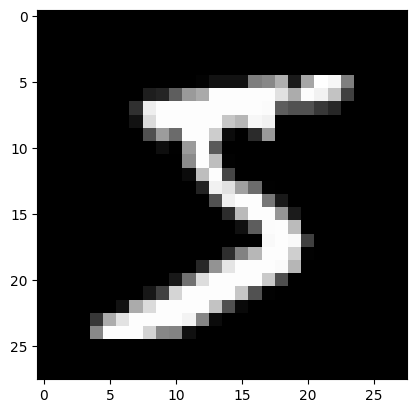

In [6]:
plt.imshow(x[0],cmap="gray")
print(f"target = {y}")

In [7]:
torch.manual_seed(101)  # for consistent results

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)


Labels:  [   7    2    3    5    8    5    3    6    9    9    1    3]


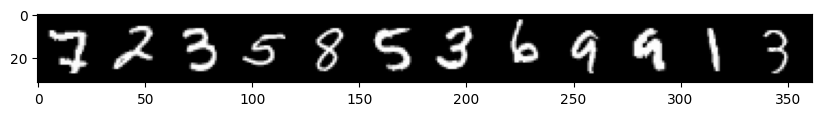

In [8]:

from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # format to widen the printed array

# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 12 labels from 100 labels (remember we set 1 batch = 100 images)
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH (Color, Width, Height) to WHC (Width, Height, Color)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));


In [9]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size=784, output_size=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(input_size,layers[0]) #input layer, layers[0]==> taken grom layer=120, look the function header
        self.fc2 = nn.Linear(layers[0],layers[1]) #hidden layer 1
        self.fc3 = nn.Linear(layers[1],output_size) #hidden layer 2 to output
    
    def forward(self,x):
        x = F.relu(self.fc1(x)) #forward input layer to hidden layer 1
        x = F.relu(self.fc2(x)) #result from previous layer, pass to the hidden layer 1 - 2
        x = self.fc3(x) #forward process from hidden layer 2 to output
        return F.log_softmax(x, dim=1) #dim=dimension

In [10]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [12]:

# Load the first batch, print its shape
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break
    

images.view(100,-1).size()

#-1 , meaning grab all after array 100 until sequence before -1, and combine them into a single dimension

Batch shape: torch.Size([100, 1, 28, 28])


torch.Size([100, 784])

In [13]:
#TRAIN DATA
import time
start_time = time.perf_counter()

epochs = 10 #try and try
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0 #train correct currently
    tst_corr = 0 #test correst
    
    # Run the training batches
    # with enumerate, we're actually going to keep track of what batch number we're on with B.
    for b, (X_train, y_train) in enumerate(train_loader): #y_train=output = label, b = batches, train_loader = return back the image and its label
        b+=1
        
        # Apply the model
        y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        loss = criterion(y_pred, y_train) #calculating error difference
 
        # calculate the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1] #check print(y_pred.data) to know data of one epoch, 1 = actual predicted value
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print results per epoch:
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())
        
    # Run the testing batches
    with torch.no_grad(): #don't update weight and bias in test data
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test, 500 because batch size for test data in cell above = 500

            # Calculating the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        t
print(f'\nDuration: {time.perf_counter() - start_time:.0f} seconds') # print the time elapsed         


epoch:  0  batch:  200 [ 20000/60000]  loss: 0.29955006  accuracy:  82.655%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.27258992  accuracy:  87.248%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.18161911  accuracy:  89.317%
epoch:  1  batch:  200 [ 20000/60000]  loss: 0.17173424  accuracy:  94.625%
epoch:  1  batch:  400 [ 40000/60000]  loss: 0.05123525  accuracy:  95.005%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.14079164  accuracy:  95.247%
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.16361409  accuracy:  96.520%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.17297991  accuracy:  96.507%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.11232079  accuracy:  96.582%
epoch:  3  batch:  200 [ 20000/60000]  loss: 0.14578477  accuracy:  97.430%
epoch:  3  batch:  400 [ 40000/60000]  loss: 0.01239444  accuracy:  97.465%
epoch:  3  batch:  600 [ 60000/60000]  loss: 0.07929572  accuracy:  97.385%
epoch:  4  batch:  200 [ 20000/60000]  loss: 0.05799930  accuracy:  98.060%
epoch:  4  b

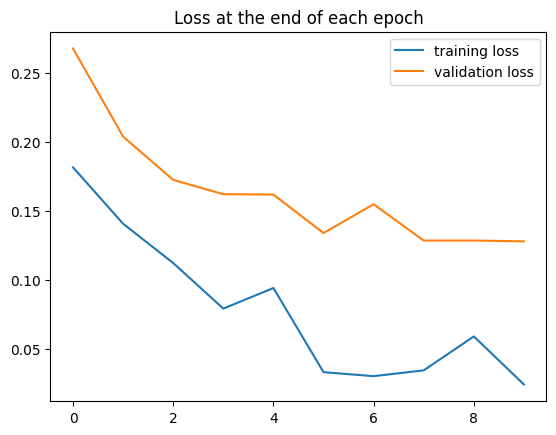

In [15]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();



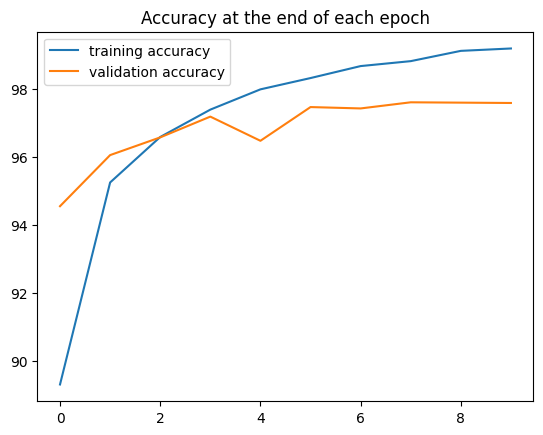

In [21]:

plt.plot([t/600 for t in train_correct], label='training accuracy') #600 because training data consist of 60,000/100 (batch size) =  600
plt.plot([t/100 for t in test_correct], label='validation accuracy') #100 because test data 10,000/100 = 100
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [22]:
#Evaluate test data
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')


#Confusion Matrix
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) #x:4 => giving space each data
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1))) #The view(-1) operation flattens the tensor,


Test accuracy: 9758/10000 =  97.580%
[[   0    1    2    3    4    5    6    7    8    9]]

[[ 969    0    1    1    2    2    1    0    3    5]
 [   0 1120    1    0    0    1    4    7    1    2]
 [   3    3 1018    7    4    0    3   10    3    0]
 [   1    3    2  986    0   17    1    4    3    7]
 [   0    0    1    0  951    1    1    0    0    7]
 [   1    0    0    3    0  849    1    0    2    5]
 [   3    3    2    1    9   11  945    0    4    1]
 [   0    0    3    2    3    0    0  996    1    2]
 [   2    6    3    8    3   10    2    6  955   11]
 [   1    0    1    2   10    1    0    5    2  969]]
